### Preparation of training sets for GuacaMol rediscovery BBO prediction

Note : Ignoring molecules containing B, Si, Se or I and molecules with charges

In [1]:
import os

guacamol_dataset = os.environ["DATA"] + "/00_datasets/Guacamol/guacamol_v1_all.smiles"
output_data_root = os.environ["DATA"] + "/00_datasets/07_BBO/GuacaMol/"

cache_location = os.environ["CACHE_CHEM2020"]


dataset_sizes = [1000, 3000, 5000, 7000, 10000, 20000, 400000]


initial_atoms_list = ["H", "B", "C", "N", "O", "F", "Si", "P", "S", "Cl", "Se", "Br", "I"]

remove_mols_with = ["B", "Si", "Se", "I"]

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit.Chem import MolToSmiles, MolFromSmiles

def contains_ignored_atom(smi, remove_mols_with):
    
    mol = MolFromSmiles(smi)
    
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in remove_mols_with:
            return True
    
    return False

def contains_charge(smi):
    """
    Checking if the given molecule contains charges
    """
    
    mol = MolFromSmiles(smi)
    for at in mol.GetAtoms():
        if at.GetFormalCharge() != 0:
            return True
    
    return False

def load_X_train_test_intersection(input_dataset_path, seed=42):
    
    all_smiles = []
    
    with open(input_dataset_path, "r") as f:
        lines = f.readlines()
        for i, smi in enumerate(lines):
            
            if i % 100000 == 0:
                print(str(i) + " : " + str(i/len(lines)*100))
                
            if not contains_ignored_atom(smi, remove_mols_with) and not contains_charge(smi):
                all_smiles.append(smi.rstrip())
            
    
    X_train_test, X_validation = train_test_split(all_smiles, test_size=20000, random_state=seed)
    
    return X_train_test, X_validation
        

In [3]:
X_train_test, X_validation = load_X_train_test_intersection(guacamol_dataset)

0 : 0.0
100000 : 6.283862162226699
200000 : 12.567724324453398
300000 : 18.851586486680098
400000 : 25.135448648906795
500000 : 31.419310811133492
600000 : 37.703172973360196
700000 : 43.98703513558689
800000 : 50.27089729781359
900000 : 56.554759460040295
1000000 : 62.838621622266984
1100000 : 69.1224837844937
1200000 : 75.40634594672039
1300000 : 81.69020810894709
1400000 : 87.97407027117379
1500000 : 94.25793243340048


In [4]:
from os.path import join
from os import makedirs
from joblib import Parallel, delayed

def canonicalize(smi):
    
    return MolToSmiles(MolFromSmiles(smi))

def save_smiles_list(smiles_list, output_path):
    
    with open(output_path, "w") as f:
        for smi in smiles_list:
            f.write(smi + "\n")

def create_save_datasets(X_train_test, X_validation, dataset_sizes, output_data_root):
    
    # Creating output folder
    makedirs(output_data_root, exist_ok=True)
    
    # Canonicalization of validation smiles
    X_validation_canon = [canonicalize(smi) for smi in X_validation]
    
    # Saving validation data
    save_smiles_list(X_validation_canon, join(output_data_root, "validation.smi"))
    
    
    for dataset_size in dataset_sizes:
        
        # Extracting current data
        X_curr = X_train_test[:dataset_size]
        
        # Canonicalization of smiles
        X_curr_canon = [canonicalize(smi) for smi in X_curr]
        
        # Saving current data
        save_smiles_list(X_curr_canon, join(output_data_root, "train_test_dataset_" + str(dataset_size) + ".smi"))


In [5]:
create_save_datasets(X_train_test, X_validation, dataset_sizes, output_data_root)

## Celecoxib

### Training/Testing dataset

In [14]:
target_smi = "CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F"

In [15]:
from bbo.objective import ECFP4SimilarityObjective
from os.path import join

obj = ECFP4SimilarityObjective(cache_location=cache_location, target_smi=target_smi, n_jobs=12)

In [22]:
d = {}

for dataset_size in dataset_sizes[:-1]:
    print(dataset_size)
    
    curr_path = join(output_data_root, "train_test_dataset_" + str(dataset_size) + ".smi")
    
    curr_smiles = []
    
    with open(curr_path, "r") as f:
        for row in f.readlines():
            curr_smiles.append(row.rstrip())
            
    # Computing objective values
    curr_y_values, successes = obj.fit_transform(curr_smiles)
    
    d[dataset_size] = curr_y_values[successes]


validation_path = join(output_data_root, "validation.smi")

validation_smiles = []

with open(validation_path, "r") as f:
    for row in f.readlines():
        validation_smiles.append(row)
        
validation_y_values, successes = obj.fit_transform(validation_smiles)
validation_y_values = validation_y_values[successes]

1000
3000
5000
7000
10000
20000


/home/jleguy/anaconda3/envs/chem2020/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


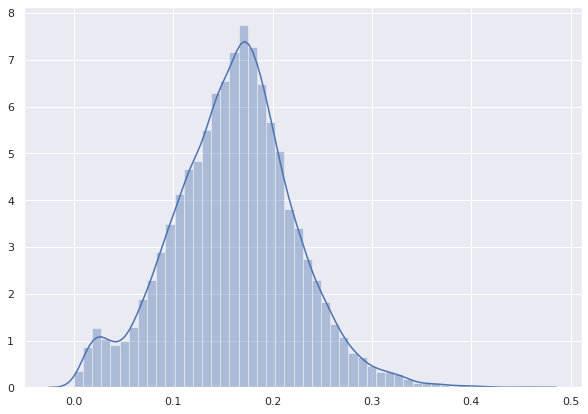

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.figure(figsize=(10, 7))

sns.distplot(d[20000])

In [24]:
import pandas as pd

pd.DataFrame.from_dict(d[20000]).describe()

0
count  20000.000000
mean       0.161138
std        0.061322
min        0.000000
25%        0.121781
50%        0.163636
75%        0.198473
max        0.460674

### Validation data

/home/jleguy/anaconda3/envs/chem2020/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


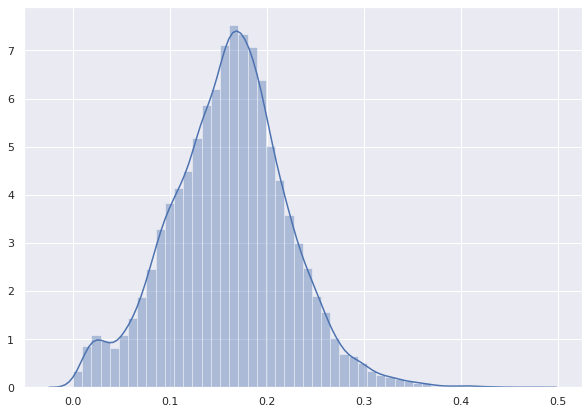

In [25]:
plt.figure(figsize=(10, 7))

sns.distplot(validation_y_values)